## PROJECT 3

In [1]:
import pandas as pd
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt
import matplotlib
import functools
import scipy.optimize
from scipy.integrate import solve_ivp, complex_ode, RK45, ode
import pandas as pd
import scipy.stats
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [2]:
# SMALL_SIZE = 20
# MEDIUM_SIZE = 22
# BIGGER_SIZE = 24
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Problem 1: using the functions from Project 2: Problem 2

In [3]:
def steady_heat(x,T_ambient, a,b,L, Phi, h, k):
    def gamma_func(a, b, k):
        return np.sqrt( (2*(a+b)*h) / (a*b*k))
    
    def c1_func(L, g, Phi, h, k):
        # g = gamma
        return - Phi/(k*g) * ((np.exp(g)**L)*(h + k*g)) * ((np.exp(-g)**L)*(h-k*g)+(np.exp(g)**L)*(h+k*g))**(-1)
    
    def c2_func(Phi, k, g, c_1):
        return Phi/(k*g) + c_1
       
    gamma = gamma_func(a,b, k)
    c1 = c1_func(L, gamma, Phi, h, k)
    c2 = c2_func(Phi, k, gamma, c1)
    
    return c1*np.exp(-gamma * x) + c2*np.exp(gamma*x) + T_ambient

def optimize_me(x, Phi, h):
    T_ambient = 21.29
    a = 0.96
    b = a
    L = 70
    k = 2.37 
    
    def gamma_func(a, b, k):
        return np.sqrt( (2*(a+b)*h) / (a*b*k))
    
    def c1_func(L, g, Phi, h, k):
        # g = gamma
        return - Phi/(k*g) * ((np.exp(g)**L)*(h + k*g)) * ((np.exp(-g)**L)*(h-k*g)+(np.exp(g)**L)*(h+k*g))**(-1)
    
    def c2_func(Phi, k, g, c_1):
        return Phi/(k*g) + c_1
       
    gamma = gamma_func(a,b, k)
    c1 = c1_func(L, gamma, Phi, h, k)
    c2 = c2_func(Phi, k, gamma, c1)
    
    return c1*np.exp(-gamma * x) + c2*np.exp(gamma*x) + T_ambient

C:\Users\adamc\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


[-5.68015751e+00  7.93851912e-04]


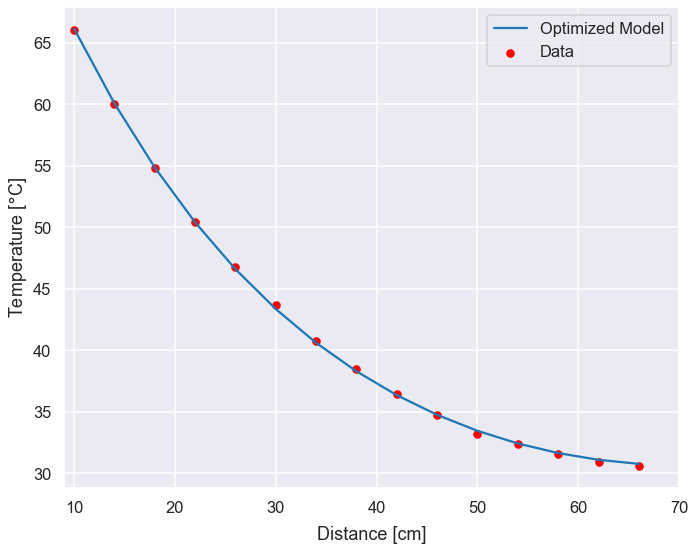

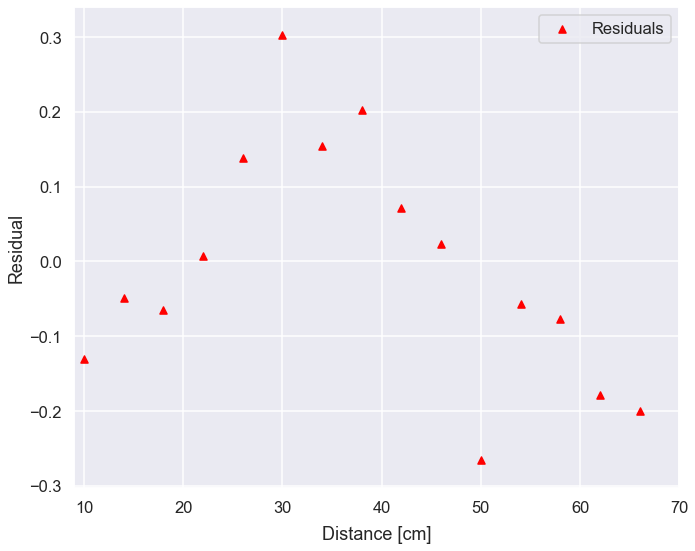

In [4]:
# Phi, h, k = -18.4, 0.00191, 2.37  # OLD FROM AL MODEL
step = 1e-4
T_amb = 21.29
a = 0.95
b = a
L = 70
k = 2.37 

x_domain = np.arange(10, 70, 4)

# FROM TABLE 3.3 of the TEXTBOOK!!!
Y = [66.04, 60.04, 54.81, 50.42, 46.74, 43.66, 40.76, 38.49,
    36.42, 34.77, 33.18, 32.36, 31.56, 30.91, 30.56]

Y_AL = [96.14, 80.12, 67.66, 57.96, 50.90, 44.84, 39.75, 39.16,
       33.31, 31.15, 29.28, 27.88, 27.18, 26.40, 25.86]

best_vals, covar = scipy.optimize.curve_fit(optimize_me, x_domain, Y, p0=[20, 0.002])
print(best_vals)

f_q = optimize_me(x_domain ,*best_vals)
R = Y - f_q
Phi, h =  best_vals

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(x_domain, Y,  s=50, c='r',label='Data')
plt.plot(x_domain, f_q, label="Optimized Model")
axe.set_xlabel('Distance [cm]', labelpad=10);
axe.set_ylabel('Temperature [$\degree$C]');
plt.xlim(9, 70)
plt.legend()
plt.tight_layout()

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(x_domain, R, s=50, marker='^' ,c='r', label="Residuals")
axe.set_xlabel('Distance [cm]', labelpad=10);
plt.xlim(9, 70)
axe.set_ylabel('Residual');
plt.legend()
plt.tight_layout()

In [5]:
# f_q = steady_heat(x_domain, T_amb, a,b,L, Phi, h, k)
# R = Y - f_q

dy_dPhi_auto = autograd.grad(steady_heat, 5) # take heat function, differentiate with respect to variable index 5, returns a new function that is dy /dPhi
dy_dPhi_auto_values = [dy_dPhi_auto(x, T_amb, a, b, L, Phi, h, k) for x in x_domain] # evaluate new function at points and pass extra parameters

dy_dh_auto = autograd.grad(steady_heat, 6)
dy_dh_auto_values = [dy_dh_auto(x, T_amb, a, b, L, Phi, h, k) for x in x_domain]

Chi_matrix = np.stack((np.asarray(dy_dPhi_auto_values),np.asarray(dy_dh_auto_values)), axis=1)

n, p = Chi_matrix.shape[0], Chi_matrix.shape[1]  # 15 observations or rows, and # 2 vars or cols
var = (1 / (n-p))* np.linalg.inv(np.matmul(np.transpose(Chi_matrix), Chi_matrix))
print(var)   # Covariance Matrix


[[ 4.09172467e-03 -5.37374129e-07]
 [-5.37374129e-07  7.62953453e-11]]


### Problem 2: using the functions from Project 2: Problem 3

In [21]:
def PSI(P, q):
    return q[0]*P**2 + q[1]*P**4 + q[2]*P**6

(a)

In [49]:
a_1, a_11, a_111 = -389.4, 761.3, 61.5
q = [a_1, a_11, a_111]
sigma = 2.2  # Error is IID and Normal with STD or Sigma = 2.2

interval_size = [81, 161, 801]  # number of equally spaces polarization values
P_array = [[] for i in range (3)]
Y_array = [[] for i in range (3)]

for i in range (3):
    P_array[i] = np.linspace(0, 0.8, interval_size[i])  # fill intervals
    Y_array[i] = PSI(P_array[i], q) + np.random.normal(0, 2.2, interval_size[i])



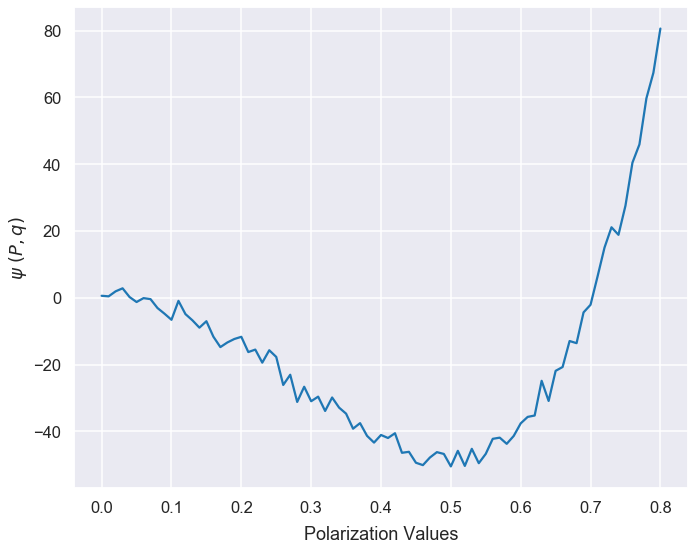

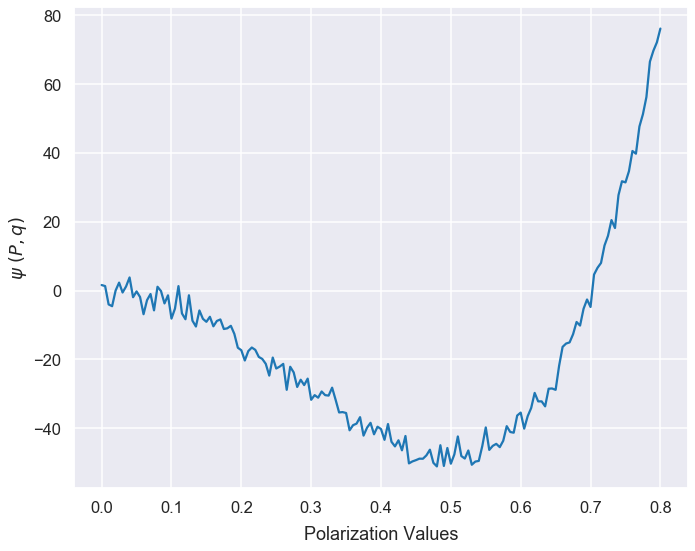

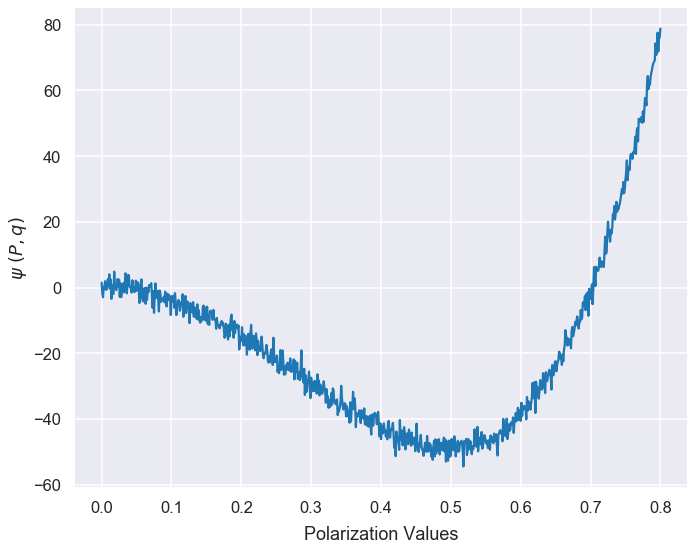

In [39]:
for i in range (3):

    fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
    axe=sns.lineplot(P_array[i], Y_array[i])
    axe.set_xlabel('Polarization Values', labelpad=10);
    axe.set_ylabel('$\psi \ (P,q)$');
    plt.tight_layout()

In [57]:
calculated_variance = np.zeros(3)

for i in range(3):
    calculated_variance[i] = (1 / (interval_size[i] - len(q))) * np.matmul(np.transpose(PSI(P_array[i], q) - Y_array[i]), PSI(P_array[i], q) - Y_array[i])
#     calculated_variance[i] = (1 / (interval_size[i] - len(q))) * np.matmul(np.transpose(Y_array[i]-PSI(P_array[i], q)), Y_array[i]-PSI(P_array[i], q))
    
np.sqrt(calculated_variance)

abs_diff = [abs(sigma**2 - var) for var in calculated_variance]

print(calculated_variance)
print(abs_diff)

[3.06830232 5.4295335  4.71950221]
[1.771697679285377, 0.5895335022184769, 0.1204977881993674]


In [58]:
np.sqrt(calculated_variance)


array([1.75165702, 2.33013594, 2.17244153])

(b)

In [59]:
def design_matrix(x):
    size = x.shape[0]
    p = 3
    DM = np.zeros((size, p))
    
    for i in range(size):
        DM[i, :] = np.array([x[i]**2, x[i]**4, x[i]**6])
    
    return DM 

# FOR Chi Matrix -> Sensitivity Matrix
def dPHI_da_1(P):
    return P**2

def dPHI_da_11(P):
    return P**4

def dPHI_da_111(P):
    return P**6

In [60]:
X = design_matrix(P_array[1])
q_ols = np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@Y_array[1]
print('q_ols:\n', q_ols )

Res = Y_array[1] - PSI(P_array[1], q_ols)
var_P = (1 / (161-3))*(np.transpose(Res)@Res)
sigma_estimated = np.sqrt(var_P)
print(f'\nEstimated Standard Deviation: {sigma_estimated:.2f}')
print(f'\nEstimated Variance: {var_P:.2f}')

Chi = np.column_stack((dPHI_da_1(P_array[1]),dPHI_da_11(P_array[1]), dPHI_da_111(P_array[1])))
covar_P = var_P*np.linalg.inv(np.transpose(Chi)@Chi)
print('\nCovariance Matrix: \n',covar_P)

q_ols:
 [-387.37804109  759.03854034   56.7139677 ]

Estimated Standard Deviation: 2.32

Estimated Variance: 5.37

Covariance Matrix: 
 [[  25.00956096 -122.06698969  136.90868027]
 [-122.06698969  648.73651971 -765.40231175]
 [ 136.90868027 -765.40231175  933.91011984]]


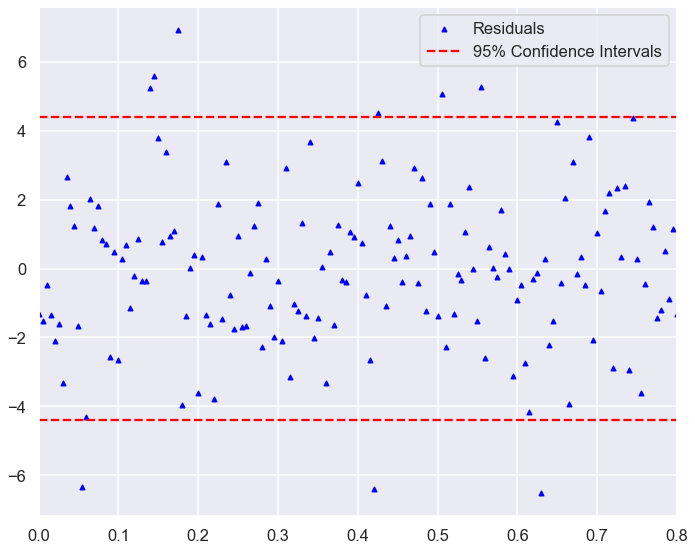

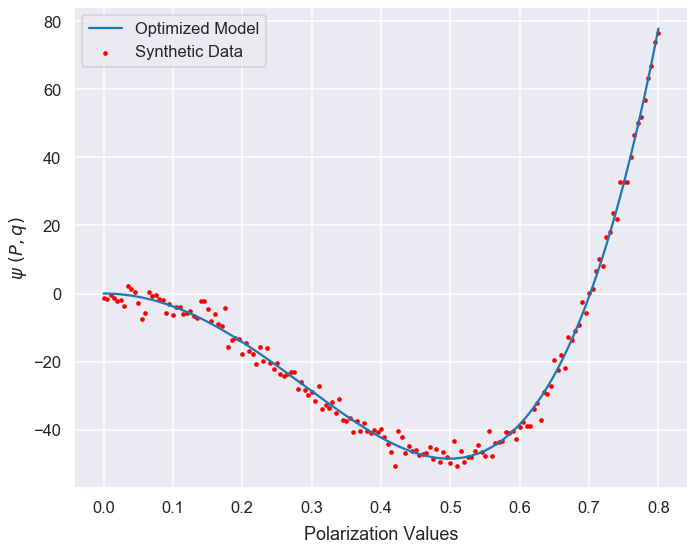

In [64]:
fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(P_array[1], Res, s=20, marker='^',  c='b', label="Residuals")
plt.hlines(2*sigma, 0, 0.8, colors='r', linestyles='--', label='95% Confidence Intervals')
plt.hlines(-2*sigma, 0, 0.8, colors='r', linestyles='--')
plt.xlim(0, 0.8)
plt.legend()
plt.tight_layout()

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(P_array[1], Y_array[1], s=10, c='r', label='Synthetic Data')
plt.plot(P_array[1], PSI(P_array[1], q_ols), label="Optimized Model")
axe.set_xlabel('Polarization Values', labelpad=10);
axe.set_ylabel('$\psi \ (P,q)$');
plt.legend()
plt.tight_layout()

Problem 3

In [65]:
def SIR(t, Y, gamma, r, delta):
    S, I, R = Y[0], Y[1], Y[2]
    N = S + I + R
#     N = 1000
    dS_dt = delta*N - delta*S - gamma*I*S
    dI_dt = gamma*I*S - (r+delta)*I
    dR_dt = r*I - delta*R
    
    dS_dt.astype(complex) , dI_dt.astype(complex) , dR_dt.astype(complex) 
#     print(dS_dt)
    return [dS_dt, dI_dt, dR_dt ]

df = pd.read_csv('SIR.txt', header=None, delim_whitespace=True)
SIR_DATA = pd.DataFrame.to_numpy(df)
y = SIR_DATA[:, 1]


def fun(q, t, y, Y_0):
    t_domain = t
    sol = solve_ivp(SIR,[0, 5], Y_0,args=(q[0], q[1], q[2]), t_eval=t_domain)
    
    minimize_me = 0
    for i in range(51):
        minimize_me += (sol.y[1][i] - y[i])**2    
    
    return minimize_me
    

In [66]:
Y_0 = [900, 100, 0]
t_domain = np.linspace(0, 5, 51)

In [67]:
solution_to_minimize_me = scipy.optimize.minimize(fun, [0.1, 0.2,  0.3], args=(t_domain, y, Y_0), bounds=((0, 1), (0, 1), (0, 1)))
solution_to_minimize_me

      fun: 20476.077867647928
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-52.44328349,  -4.66134225,   5.83422661])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 92
      nit: 16
   status: 0
  success: True
        x: array([0.00999172, 0.79693132, 0.19529234])

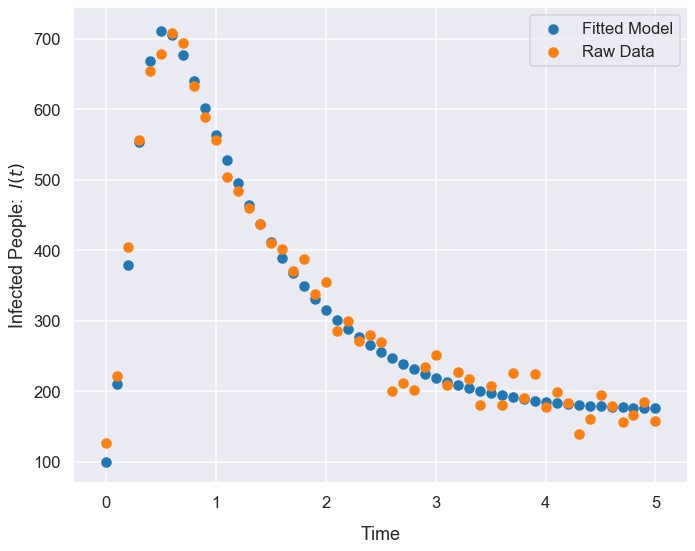

In [68]:
fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
sol_optimal = solve_ivp(SIR,[0, 5], Y_0,args=solution_to_minimize_me.x, t_eval=t_domain, rtol=1e-6)
plt.scatter(t_domain, sol_optimal.y[1], label='Fitted Model')
plt.scatter(SIR_DATA[:,0], y, label='Raw Data')
plt.ylabel('Infected People:  '+r'$I(t)$')
plt.xlabel('Time', labelpad=15)
plt.legend()
plt.tight_layout()

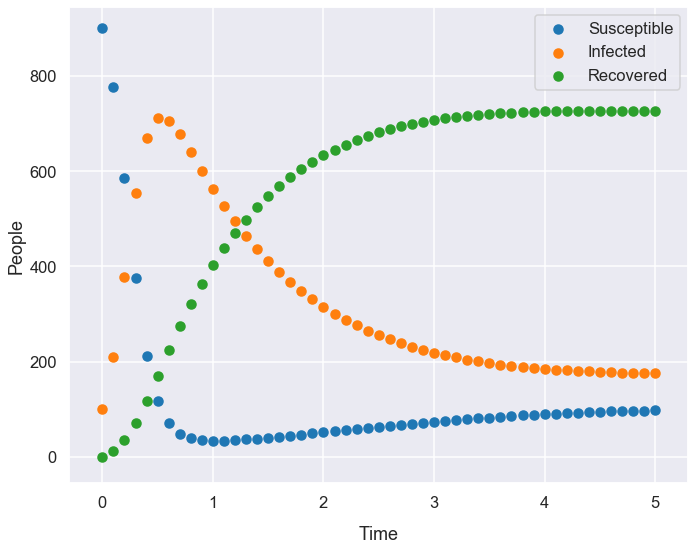

In [69]:
fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(t_domain, sol_optimal.y[0], label='Susceptible')
plt.scatter(t_domain, sol_optimal.y[1], label='Infected')
plt.scatter(t_domain, sol_optimal.y[2], label='Recovered')
plt.ylabel('People')
plt.xlabel('Time', labelpad=15)
plt.legend()
plt.tight_layout()


In [19]:
def sensitvity_gen(variable_of_interest_idx, nominal_params):

    sensitivity_array = np.zeros((t_domain.shape[0], 3))
    for i in range(3):
        h = 1e-6;
        fd_params_h = np.copy(nominal_params)
        fd_params_h[i] =  fd_params_h[i] + h
        sol_h = solve_ivp(SIR,[0, 5], Y_0, args=fd_params_h, t_eval=t_domain, rtol=1e-6)
        sol = solve_ivp(SIR,[0, 5], Y_0, args=nominal_params, t_eval=t_domain, rtol=1e-6)

        # ith col for ith parameter, sol_1 is I variable
#         print(np.imag(sol.y[variable_of_interest_idx]))
        sensitivity_array[:, i] = (sol_h.y[1] - sol.y[1]) / h
        
    return sensitivity_array
        

In [20]:
Chi_SIR = sensitvity_gen(1, solution_to_minimize_me.x)
Res_SIR = SIR_DATA[:, 1] - sol_optimal.y[1]
var_SIR = (1 / (51-3))*(np.transpose(Res_SIR)@Res_SIR)

covar_SIR = var_SIR*np.linalg.inv(np.transpose(Chi_SIR)@Chi_SIR)
rank_of_covar_SIR = np.linalg.matrix_rank(covar_SIR)
print(covar_SIR)
print('RANK of COVAR SIR MODEL:', rank_of_covar_SIR)

t_inv = scipy.stats.t.ppf(1-0.05/2, 51-3)

gamma_CI = t_inv*np.sqrt(var_SIR)*np.sqrt(covar_SIR[0][0]/var_SIR)
r_CI =  t_inv*np.sqrt(var_SIR)*np.sqrt(covar_SIR[1][1]/var_SIR)
delta_CI = t_inv*np.sqrt(var_SIR)*np.sqrt(covar_SIR[2][2]/var_SIR)



[[4.67138082e-08 1.49766167e-07 4.91644719e-08]
 [1.49766167e-07 1.98942803e-04 1.11055072e-04]
 [4.91644719e-08 1.11055072e-04 1.02198139e-04]]
RANK of COVAR SIR MODEL: 3
